# Multi-sample tissue compartment detection

## 1. Integrate samples with Scanorama

In [1]:
import scanorama
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import chrysalis as ch

We begin by loading the anterior and posterior mouse brain samples. We proceed by removing the low-quality capture spots and genes that are expressed in fewer than 10 spots and appending samples to the `adatas` list. We then run `scanorama` using the dedicated `scanpy` function to correct the expression matrices.

In [2]:
samples = ['V1_Mouse_Brain_Sagittal_Anterior_Section_2', 'V1_Mouse_Brain_Sagittal_Posterior_Section_2']

adatas = []

for sample in samples:
    ad = sc.datasets.visium_sge(sample_id=sample)
    ad.var_names_make_unique()
    
    sc.pp.calculate_qc_metrics(ad, inplace=True)
    sc.pp.filter_cells(ad, min_counts=1000)
    sc.pp.filter_genes(ad, min_cells=10)
    
    sc.pp.normalize_total(ad, inplace=True, target_sum=1e4)
    sc.pp.log1p(ad)
    
    ch.detect_svgs(ad)
    
    adatas.append(ad)


Calculating SVGs: 100%|██████████| 12206/12206 [02:21<00:00, 86.26it/s] 


In [3]:
adatas_cor = scanorama.correct_scanpy(adatas, return_dimred=True)

Found 16415 genes among all datasets
[[0.         0.50372208]
 [0.         0.        ]]
Processing datasets (0, 1)


`ch.integrate_adatas` can be used to calculate spatially variable genes (SVGs) for each sample in the input list or dictionary and concatenate the identified SVG gene sets across samples. Sample IDs are automatically assigned [0, 1, ...] if not stated otherwise.

## 2. Run chrysalis on the integrated samples

In [4]:
adata = ch.integrate_adatas(adatas_cor, sample_col='sample')

A single `AnnData` object is created with a `.obs` columns storing the union of SVGs. Sample-wise Moran's I values and the identified SVGs are stored in `adata.varm`. `adata.obs['sample']` stores the sample IDs for each observation.

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 6104 × 16415
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbols', 'spatially_variable'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'X_scanorama'
    varm: 'spatially_variable', "Moran's I"


As calculatting SVGs might take longer depending on the dataset size, it is recommended to save the `AnnData` object after this step, or to save the samples individually before appending them to `adatas` in cell 1.

```
adata.write('mouse_ap_integrated.h5ad')

adata = sc.read_h5ad('mouse_ap_integrated.h5ad')
```

We can proceed by calling `ch.pca` and `ch.aa` as shown in the previous tutorial. By looking at the explained variance curve, we can select 10 tissue compartments, however, the number of compartments can be increased depending on the resolution that is suitable for the specific dataset or inquiry.

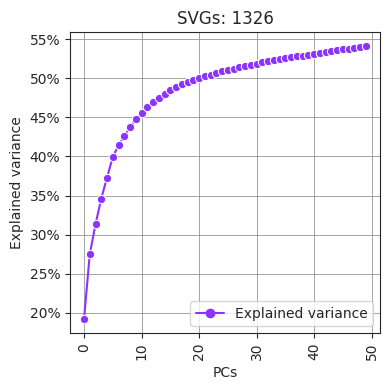

In [6]:
adata.var.index = adata.var['gene_symbols']
adata.var_names = adata.var['gene_symbols']
ch.pca(adata)

ch.plot_explained_variance(adata)
plt.show()

After tissue compartment inference, we may visualize the samples stored in the integrated AnnData object simultaniously using `ch.plot_samples`.  

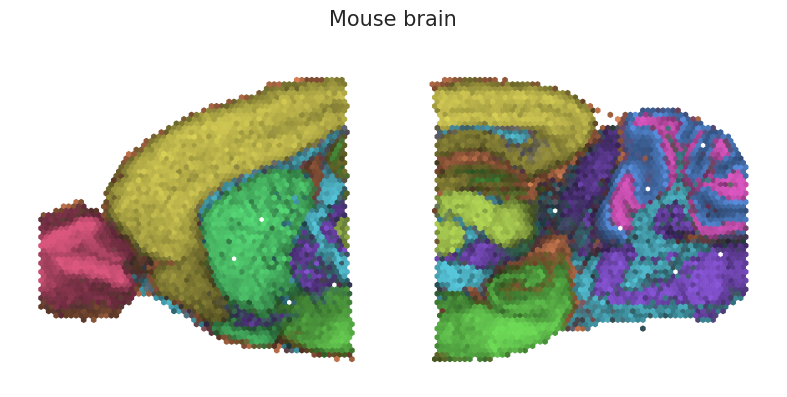

In [7]:
ch.aa(adata, n_pcs=20, n_archetypes=10)

ch.plot_samples(adata, 1, 2, dim=10, suptitle='Mouse brain', spot_size=4.5, show_title=False)
plt.show()

If we would like to examine the spatial distribution of a specific tissue compartment, we can visualize it using the `selected_comp` parameter.

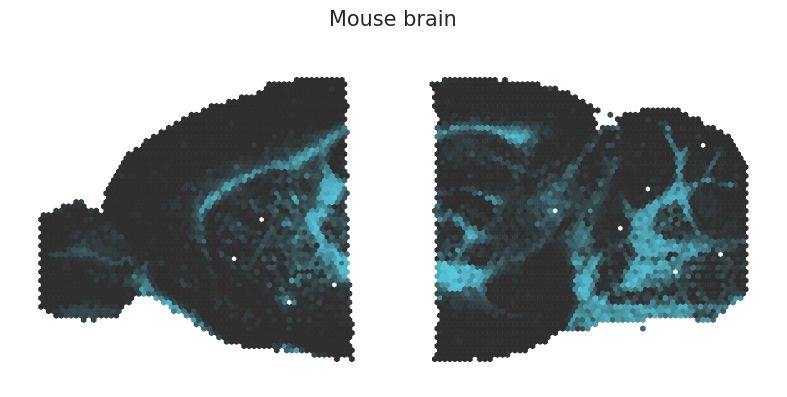

In [8]:
ch.plot_samples(adata, 1, 2, dim=10, selected_comp=9, suptitle='Mouse brain', spot_size=4.5, show_title=False)
plt.show()

We can observe clear continuity between tissue compartments across samples indicating that the integration was successful.

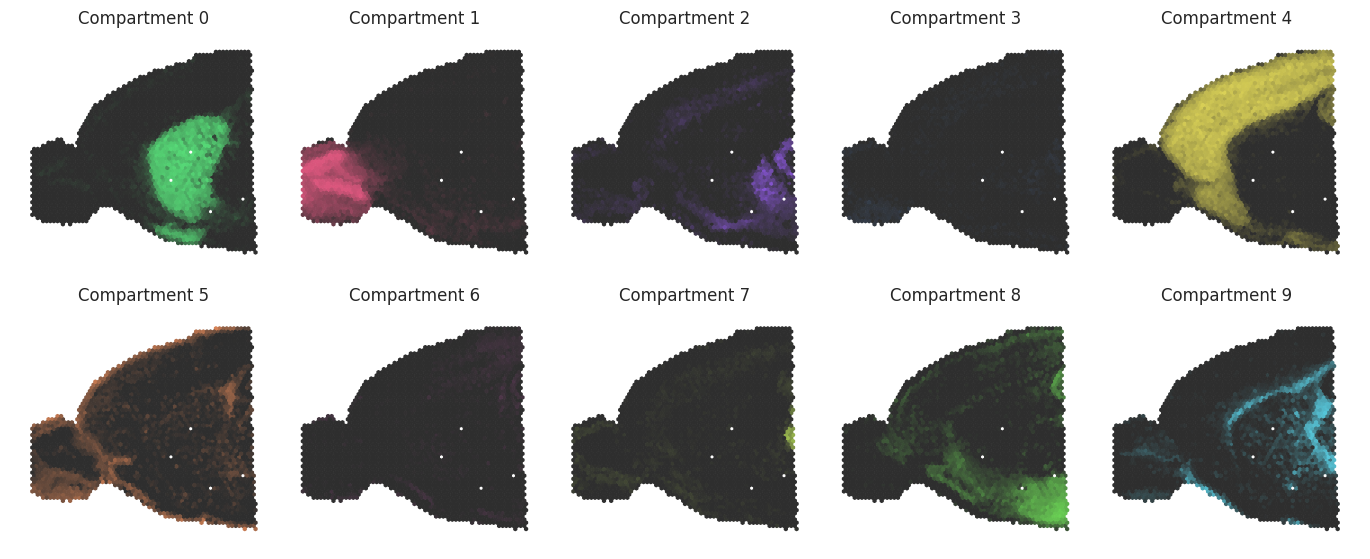

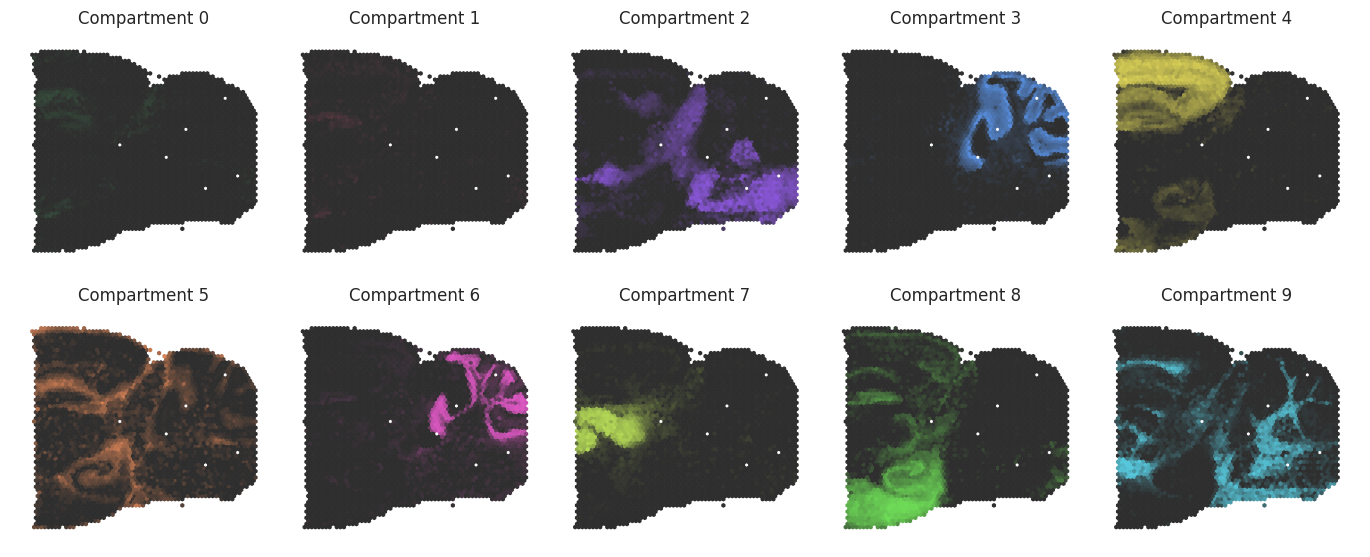

In [9]:
for i in np.unique(adata.obs['sample']):
    ch.plot_compartments(adata, sample_id=i, ncols=5, rasterized=True, title_size=12)
    plt.show()

Finally we can take a look at the integrated tissue compartment signatures.

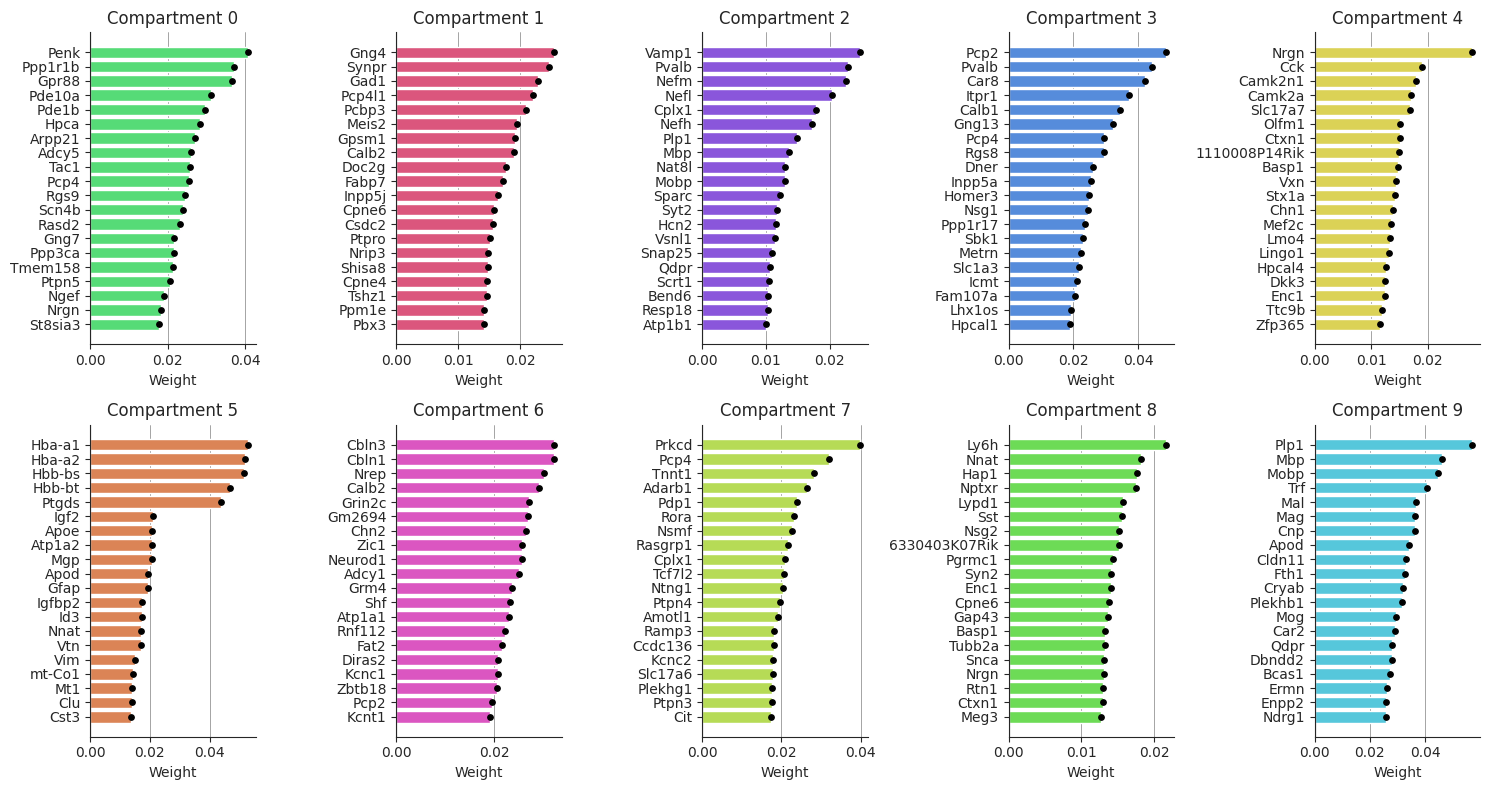

In [10]:
ch.plot_weights(adata, ncols=5)
plt.show()